<a href="https://colab.research.google.com/github/mortarialex/cienciadedados2/blob/main/cd2_1704.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 17/04

---

## **Validação Cruzada**

---

*Avaliação Holdout*: alta variância, subutilização de dados, datasets pequenos

---

A validação cruzada mitiga alguns problemas da holdout.

É preferível em datasets pequenos, pois, separa em subconjuntos e executa o treinamento **k** vezes, alterando os dados de teste e treino a cada iteração. Também reduz o viés de avaliação.
O lado ruim é que possui um custo computacional maior e os dados temporais exigem uma validação específica.

Se os dados possuirem um desbalanço de instâncias no atributo alvo, utilizados *Statified k-fold*. É importante manter o balanço de instância nas classes para generalizar de forma mais prática. Fraudes e doenças raras são exemplos de dados onde é possível observar desbalanceamento de instâncias.


**Não se aplica a problemas de regressão pois não são valores numéricos**

---

In [ ]:
import pandas as pd

data = pd.read_csv("inadimplentes.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   score_credito  1000 non-null   int64
 1   idade          1000 non-null   int64
 2   inadimplente   1000 non-null   int64
dtypes: int64(3)
memory usage: 23.6 KB


In [ ]:
print("Distribuição original: ", data['inadimplente'].value_counts)

Distribuição original:  <bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: inadimplente, Length: 1000, dtype: int64>


In [ ]:
X = data.drop('inadimplente', axis = 1)
y = data['inadimplente']

In [ ]:
from sklearn.metrics import (recall_score, precision_score, f1_score,
                            accuracy_score, confusion_matrix,
                            roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt
from IPython.display import display

def avalia_modelo(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Recall': recall_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Acurácia': accuracy_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }

    print("\nMatriz de Confusão:")
    display(pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=['Previsto Não', 'Previsto Sim'],
             index=['Real Não', 'Real Sim']))

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('Curva ROC')
    plt.show()

    return pd.DataFrame([metrics])


Matriz de Confusão:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Previsto Não,Previsto Sim
Real Não,164,0
Real Sim,36,0


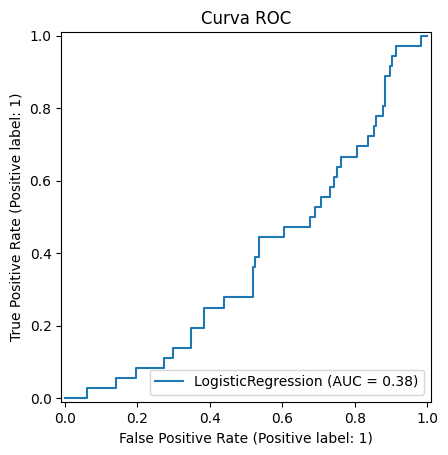

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import (recall_score, precision_score, f1_score,
                            accuracy_score, confusion_matrix,
                            roc_auc_score, RocCurveDisplay)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = LogisticRegression(random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
holdout_metrics = avalia_modelo(X_train, X_test, y_train, y_test, modelo)


In [ ]:
from sklearn.model_selection import cross_validate, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_metrics = cross_validate(modelo, X, y, cv=kf, scoring=['recall', 'precision', 'f1', 'accuracy', 'roc_auc'], return_train_score=False)

print("Métricas:")

kfMetrics = pd.DataFrame(
    {
        'Recall': cv_metrics['test_recall'],
        'Precisão': cv_metrics['test_precision'],
        'F1-Score': cv_metrics['test_f1'],
        'Acurácia': cv_metrics['test_accuracy'],
        'AUC-ROC': cv_metrics['test_roc_auc']
    }
)

kfMetrics

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Métricas:


,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
0,0.0,0.0,0.0,0.820,0.381436
1,0.0,0.0,0.0,0.880,0.621922
2,0.0,0.0,0.0,0.840,0.506789
3,0.0,0.0,0.0,0.880,0.494318
4,0.0,0.0,0.0,0.865,0.413402


In [ ]:
display(kfMetrics.describe().loc[['mean', 'std']])

,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
mean,0.0,0.0,0.0,0.857000,0.483574
std,0.0,0.0,0.0,0.026363,0.093743


In [ ]:
from sklearn.model_selection import StratifiedKFold

# validação cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvMetricsSkf = cross_validate(modelo, X, y, cv=skf, scoring=['recall', 'precision', 'f1', 'accuracy', 'roc_auc'], return_train_score=False)

print("Metricas kfold estratificado")
skfMetrics = pd.DataFrame(
    {
        'Recall': cvMetricsSkf['test_recall'],
        'Precisão': cvMetricsSkf['test_precision'],
        'F1-Score': cvMetricsSkf['test_f1'],
        'Acurácia': cvMetricsSkf['test_accuracy'],
        'AUC-ROC': cvMetricsSkf['test_roc_auc']
    }
)

skfMetrics

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metricas kfold estratificado


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Recall,Precisão,F1-Score,Acurácia,AUC-ROC
0,0.0,0.0,0.0,0.860,0.580357
1,0.0,0.0,0.0,0.860,0.442276
2,0.0,0.0,0.0,0.855,0.558782
3,0.0,0.0,0.0,0.855,0.509377
4,0.0,0.0,0.0,0.855,0.564227


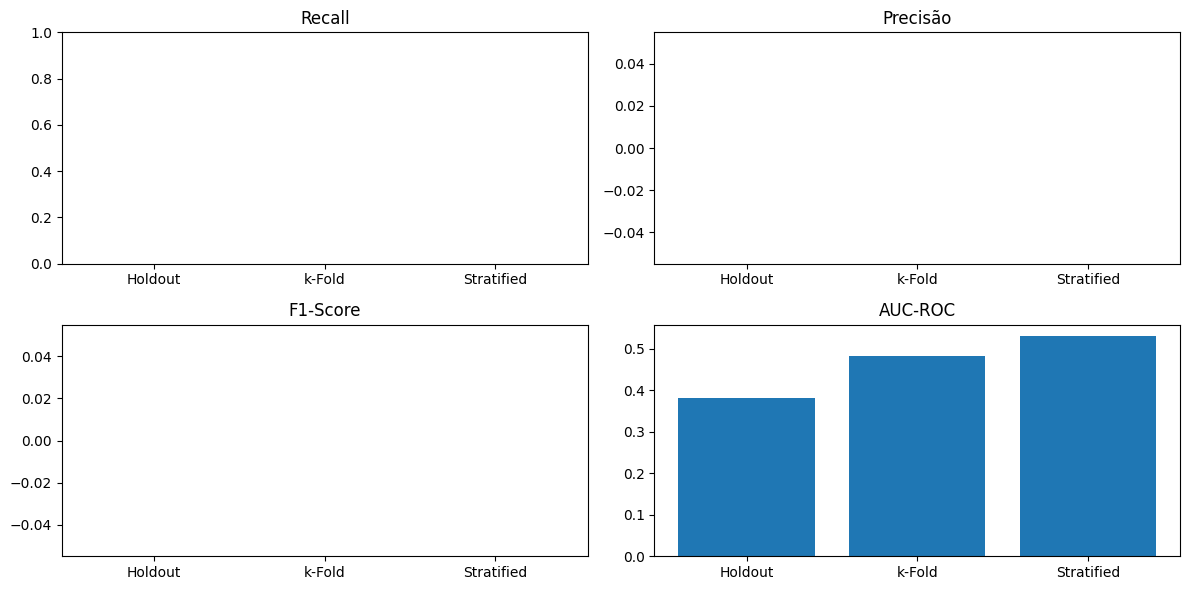

In [ ]:
plt.figure(figsize=(12, 6))
metrics_list = ['Recall', 'Precisão', 'F1-Score', 'AUC-ROC']

for i, metric in enumerate(metrics_list, 1):
    plt.subplot(2, 2, i)
    plt.bar(['Holdout', 'k-Fold', 'Stratified'],
            [holdout_metrics[metric].values[0],
             kfMetrics[metric].mean(),
             skfMetrics[metric].mean()])
    plt.title(metric)
    if metric == 'Recall':
        plt.ylim(0, 1)

plt.tight_layout()
plt.show()

**Exercício 1:** Até aqui, ficou claro que a melhor abordagem para este dataset é a validação cruzada estratificada, mesmo ela não possuindo a melhor curva ROC como podemos ver no gráfico 4. Isso acontece porque o modelo é mais robusto já que foi exposto a dados equilibrados e diferentes em cada fase de treino e teste. Partido desse cenário, tente realizar algum pré-processamento nos dados e verifique se as métricas melhoram ou pioram.

**Exercício 2:** Pegue o dataset ``Titanic`` que usamos na aula 3 e faça a previsão de quem sobreviveu e quem faleceu. Decida qual a melhor estratégia de validação e descreva suas conclusões parciais a cada célula do seu Google Colab. Faça as devidas transformações nos dados.